In [1]:
import pandas as pd
import numpy as np
import string
# import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from sklearn.feature_extraction.text import TfidfVectorizer
!pip install pyspellchecker
!pip install langdetect
# from spellchecker import SpellChecker
# from langdetect import detect
import re
from sklearn.metrics import accuracy_score
# !pip install pyenchant
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import SimpleRNN,Bidirectional

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 14.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993224 sha256=93f91088c84b841c268ece96335637302a90ef029fd025d8e3e7dd2fceea4024
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [2]:
from keras.layers import Input, Dense, Dropout, Embedding, Conv1D, MaxPooling1D, LSTM, concatenate,Flatten,GlobalMaxPool1D
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from keras.layers import Bidirectional
from sklearn.metrics import confusion_matrix

# Preprocessing

In [21]:
class TextPreprocessor:
  def __init__(self):
    self.slang_map = {
    "u": "you",
    "luv": "love",
    "ur": "your",
    "r": "are",
    "ya": "you",
    "wanna": "want to",
    "gonna": "going to",
    "wat": "what",
    "wtf": "what the f*ck",
    "omg": "oh my god",
    "btw": "by the way",}
    self.emoji_dict = {"😊": "positive", "😢": "negative", "😠": "negative", "😡": "negative", "😃": "positive",
                  "❤️": "positive", "😍": "positive", "😎": "positive", "😔": "negative", "😒": "negative",
                  "😞": "negative", "😖": "negative", "😘": "positive", "😜": "positive", "😝": "positive",
                  "😤": "negative", "😮": "neutral", "😯": "neutral", "😪": "negative", "😫": "negative",
                  "😴": "neutral", "😌": "neutral", "😛": "positive", "😚": "positive", "😙": "positive",
                  "😗": "positive", "😘": "positive", "😉": "positive", "😊": "positive"}




  def remove_non_english_words(self,text_list):
    english_text = []
    for text in text_list:
        text = re.sub(r'[^a-zA-Z\s]+', '', text)

        english_text.append(text)
    return english_text



  def clean_tokens(self,tokens):
        # remove URLs
        tokens = [re.sub(r'http\S+', '', token) for token in tokens]

        # remove numbers
        tokens = [re.sub(r'\d+', '', token) for token in tokens]

        # remove special characters
        tokens = [re.sub(r'[^\w\s]', '', token) for token in tokens]

        return tokens

  def handle_slang_words(self,text):
        for slang, standard in self.slang_map.items():
            if text == slang:
              text = text.replace(slang, standard)
        return text

  def unique_tokens(self,tokens):
        return list(set(tokens))

  def handle_negations(self,tokens):
        return ["not" + token if token in ['not', 'never', 'no', 'nothing', 'neither', 'nor'] else token for token in tokens]

  def create_ngrams(self,tokens, n):
        if not tokens:
            return []
        return [" ".join(ngram) for ngram in list(nltk.ngrams(tokens, n))]

  def remove_special_characters(self,tokens):
      return [re.sub(r'[^\w\s]', '', token) for token in tokens]

  def remove_excessive_whitespaces(self,tokens):
      return [token.strip() for token in tokens if token.strip()]

  def handle_emojis(self,text):
      cleaned_text = []
      for word in text:
          if word in self.emoji_dict:
              sentiment = self.emoji_dict[word]
              cleaned_text.append(sentiment)
          else:
              cleaned_text.append(word)
      return cleaned_text


  def preprocessing(self,text):
      #tonkenize
      tokens = nltk.word_tokenize(text)

      # Removing non-English words
      tokens=self.remove_non_english_words(tokens)

      #stop words
      stop_words = set(nltk.corpus.stopwords.words('english'))
      negation_words = {
        'no', 'not', 'never', 'neither', 'nor', 'none', 'nobody', 'nothing',
        'nowhere', 'hardly', 'barely', 'scarcely', 'lack', 'lacks', 'lacked',
        'lacking', 'without', 'against', 'except', 'instead', 'cannot', 'can\'t',
        'isn\'t', 'doesn\'t', 'these'
        }
      tokens = [token for token in tokens if token.lower() not in stop_words or token.lower() in negation_words]

      # handling emojis
      tokens = self.handle_emojis(tokens)

      # Removing punctuation
      tokens = [token for token in tokens if token not in string.punctuation]

      tokens = self.clean_tokens(tokens)

      # handle negations
      #tokens=self.handle_negations(tokens)

      #misspelled words
      #tokens=self.correct_misspelled_words(tokens)

      #slang words handling
      tokens=self.handle_slang_words(tokens)

      # Removing special characters
      tokens= self.remove_special_characters(tokens)

      #lemmatization
      lemmatizer = WordNetLemmatizer()
      tokens = [lemmatizer.lemmatize(token) for token in tokens]

      # remove duplicates
      tokens = self.unique_tokens(tokens)

      return tokens


## some postprocessing

In [ ]:
# def remove_rows(df, column, chars):
#     """
#     Remove rows from the input DataFrame that contain any of the input characters in the input column.

#     :param df: the input DataFrame to modify
#     :param column: the column to search for the input characters
#     :param chars: a list of characters that should trigger the removal of a row
#     """
#     # Loop over the rows of the DataFrame
#     for i, row in df.iterrows():
#         # Check if any of the characters in the input list are present in the current row of the input column
#         if any(char in row[column] for char in chars):
#             # If so, remove the current row from the DataFrame
#             df.drop(i, inplace=True)
# chars = ['Ù','Ø','§','®','©','‡','±','¹','¬','¡','ƒ','µ']
# remove_rows(df, "review", chars)

# Loading Dataset

In [105]:
df = pd.read_excel("a5r_data_isa3.xlsx")


In [106]:
df=df[['Review','Rating']]
df

,Review,Rating
0,If I can evaluate this seller with 0 star I wo...,0
1,"Brand orderd: iafer, however, the received is ...",0
2,Another product delivered Delivered a differen...,0
3,Fraud !! Be careful dealing with this seller ....,0
4,"Completely different item , different brand an...",0
...,...,...
49228,It makes my lashes perfect,1
49229,not original,0
49230,Very bad material and totally useless,0
49231,Original,1


In [7]:
# df2 = pd.read_excel("/content/Negative_Electronics.xlsx")
# df2

In [8]:
# df=pd.concat([df,df2])

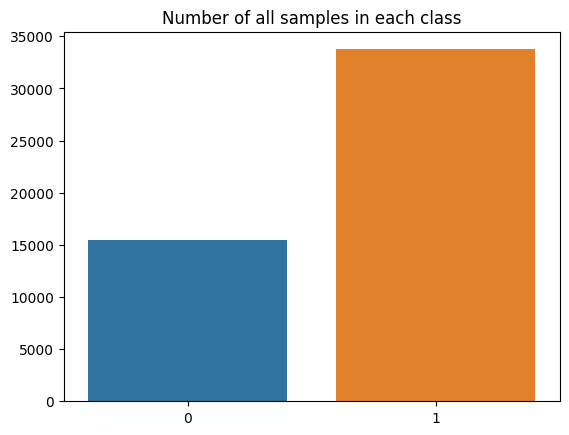

1    33748
0    15485
Name: Rating, dtype: int64


In [57]:
class_counts = df['Rating'].value_counts()
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Number of all samples in each class')
plt.show()
print(class_counts)

## Data Preprocessing


In [25]:
df_preprocessor = TextPreprocessor()
train_text_list_df = df['Review'].tolist()

In [54]:
df_processed_texts = []
for text in train_text_list_df:
    df_processed_texts.append(df_preprocessor.preprocessing(text))

In [53]:
# df_processed_texts = []
# df_reviews = []
# df_rating = []

# train_text_list_df = df['Review'].tolist()
# train_rating_list_df = df['Rating'].tolist()

# for i, text in enumerate(train_text_list_df):
#     if isinstance(text, str):
#         df_processed_texts.append(df_preprocessor.preprocessing(text))
#         df_reviews.append(text)
#         df_rating.append(train_rating_list_df[i])
#     elif isinstance(text, bytes):
#         text_str = text.decode('utf-8')
#         df_processed_texts.append(df_preprocessor.preprocessing(text_str))
#         df_reviews.append(text_str)
#         df_rating.append(train_rating_list_df[i])
#     elif isinstance(text, float):
#         text_str = str(text)
#         df_processed_texts.append(df_preprocessor.preprocessing(text_str))
#         df_reviews.append(text_str)
#         df_rating.append(train_rating_list_df[i])
#     else:
#         raise TypeError("Expected string, bytes-like object, or float, but received {}".format(type(text)))


In [59]:
# df=pd.DataFrame()
# df['Review']=df_reviews
# df['Rating']=df_rating
# df['processed_text']=df_processed_texts

In [107]:
df['processed_text'] = df_processed_texts
df['processed_text'] = df['processed_text'].apply(' '.join)

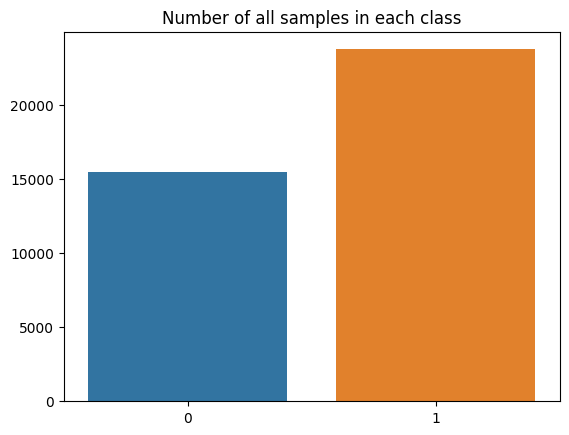

1    23748
0    15485
Name: Rating, dtype: int64


In [112]:
class_counts = df['Rating'].value_counts()
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Number of all samples in each class')
plt.show()
print(class_counts)

In [109]:
df = df.drop(df[df['Rating'] == 1].head(10000).index)

In [110]:
df.reset_index(drop=True,inplace=True)

In [111]:
df

,Review,Rating,processed_text
0,If I can evaluate this seller with 0 star I wo...,0,color ordered send would check pick seller di ...
1,"Brand orderd: iafer, however, the received is ...",0,Brand received iafer le orderd store Nillkin p...
2,Another product delivered Delivered a differen...,0,brand lower delivered product different Delive...
3,Fraud !! Be careful dealing with this seller ....,0,color brand another bad quality sent intended ...
4,"Completely different item , different brand an...",0,Completely brand product colour sent scam abso...
...,...,...,...
39228,It makes my lashes perfect,1,make perfect lash
39229,not original,0,original not
39230,Very bad material and totally useless,0,useless bad totally material
39231,Original,1,Original


In [131]:
df.to_excel("Final_English_Preprocessed_isa.xlsx")

# Data Splitting

In [115]:
from sklearn.model_selection import train_test_split

# Split your data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(
    df["processed_text"], df["Rating"], test_size=0.1, random_state=42,shuffle = True)

# # Split the training data again into training and validation sets
# x_train_embedded, x_val_embedded, y_train_embedded, y_val_embedded = train_test_split(
#      x_train_embedded, y_train_embedded, test_size=0.2, random_state=42)

In [116]:
print('training data: ', x_train.shape)
print('testing data: ', x_test.shape)

training data:  (22721,)
testing data:  (2525,)


# Word Embedding

In [117]:
word_vectorizer = TfidfVectorizer(ngram_range=(1,2),max_features=25000)
unigramdataGet= word_vectorizer.fit_transform(x_train.astype('str'))
unigramdataGet = unigramdataGet.toarray()
vocab = word_vectorizer.get_feature_names_out()
x_train_embedded=pd.DataFrame(unigramdataGet, columns=vocab)

In [94]:
import pickle
pickle.dump(word_vectorizer, open("Approach2_ML_English_TFIDF.pk", "wb"))

In [118]:
x_train_embedded

,aa,aac,aac nt,ab,abbastanza,aber,ability,ability noise,able,able call,...,zoom team,zu,zu die,zudem,zufrieden,zum,zur,zurck,zwei,zx
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22716,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22717,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22718,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22719,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [119]:
unigramdataGet= word_vectorizer.transform(x_test.astype('str'))
unigramdataGet = unigramdataGet.toarray()
vocab = word_vectorizer.get_feature_names_out()
x_test_embedded=pd.DataFrame(unigramdataGet, columns=vocab)

In [120]:
x_test_embedded

,aa,aac,aac nt,ab,abbastanza,aber,ability,ability noise,able,able call,...,zoom team,zu,zu die,zudem,zufrieden,zum,zur,zurck,zwei,zx
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2520,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2521,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2522,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2523,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# ML models

In [91]:
from sklearn.metrics import log_loss

### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
trained_clf_random_forest = RandomForestClassifier(n_estimators=50).fit(x_train_embedded, y_train)

In [ ]:
# Predict the labels of the test data
test_predictions = trained_clf_random_forest.predict(x_test_embedded)
print("Training accuracy  :", trained_clf_random_forest.score(x_train_embedded, y_train))
print("Testing accuracy   :",accuracy_score(test_predictions, y_test))
test_probabilities = trained_clf_random_forest.predict_proba(x_test_embedded)
train_probabilities = trained_clf_random_forest.predict_proba(x_train_embedded)

test_loss = log_loss(y_test, test_probabilities)
train_loss = log_loss(y_train, train_probabilities)
print("Training loss      :", train_loss)
print("Testing loss       :", test_loss)

Training accuracy  : 0.9956288247783189
Testing accuracy   : 0.8978436433269503
Training loss      : 0.07886048734412338
Testing loss       : 0.27474044293313277


### Logistic Regression


In [121]:
from sklearn.linear_model import LogisticRegression
# Train the logistic regression model
clf = LogisticRegression(solver='lbfgs').fit(x_train_embedded,y_train)

# Predict the labels of the test data
test_predictions = clf.predict(x_test_embedded)
print("Training accuracy  :", clf.score(x_train_embedded, y_train))
print("Testing accuracy   :",accuracy_score(test_predictions, y_test))
test_probabilities = clf.predict_proba(x_test_embedded)
train_probabilities = clf.predict_proba(x_train_embedded)

test_loss = log_loss(y_test, test_probabilities)
train_loss = log_loss(y_train, train_probabilities)
print("Training loss      :", train_loss)
print("Testing loss       :", test_loss)

Training accuracy  : 0.929712600677787
Testing accuracy   : 0.9172277227722773
Training loss      : 0.1773595486590084
Testing loss       : 0.19875228739879208


In [135]:
df_preprocessor = TextPreprocessor()
positive_reviews = [
    "I absolutely love this phone! The camera quality is exceptional, and the battery life lasts all day. Highly recommended!",
    "The performance of this phone is outstanding. It runs smoothly, and the apps load quickly. The display is vibrant and sharp.",
    "This phone has a sleek and stylish design. The screen-to-body ratio is impressive, and the fingerprint sensor works flawlessly.",
    "The audio quality on this phone is superb. The speakers produce clear and loud sound, perfect for watching videos or listening to music.",
    "The phone's user interface is intuitive and user-friendly. It's easy to navigate through the settings and customize the phone to my liking."
]

negative_reviews = [
    "I'm disappointed with the battery life of this phone. It drains quickly, and I have to charge it multiple times a day.",
    "The camera on this phone doesn't meet my expectations. The photos often turn out blurry, especially in low-light conditions.",
    "The phone tends to overheat during prolonged usage. It becomes uncomfortable to hold, and the performance slows down.",
    "I've experienced frequent software glitches with this phone. It freezes occasionally and requires a restart to function properly.",
    "The build quality of this phone is subpar. The materials used feel cheap, and the phone doesn't feel sturdy in hand."
]

reviews = positive_reviews + negative_reviews
testing = [df_preprocessor.preprocessing(text) for text in reviews]
# print(testing)
result=[]
for test in testing:
    result.append(' '.join(test))
result

['battery love phone day life absolutely exceptional quality Highly last camera recommended',
 'display phone outstanding run quickly load vibrant apps sharp performance smoothly',
 'fingerprint impressive phone sleek design sensor work ratio flawlessly stylish screentobody',
 'produce listening phone watching perfect quality superb sound video music clear speaker loud audio',
 'phone user interface navigate liking intuitive easy setting userfriendly customize',
 'battery drain phone day life disappointed quickly multiple time charge',
 'expectation often blurry phone especially meet nt condition camera turn lowlight photo',
 'phone usage prolonged becomes uncomfortable slows hold tends overheat performance',
 'glitch phone software occasionally properly requires restart freeze experienced function frequent',
 'sturdy phone hand cheap nt subpar quality used material feel build']

In [136]:
unigramdataGet= word_vectorizer.transform(result)
unigramdataGet = unigramdataGet.toarray()
vocab = word_vectorizer.get_feature_names_out()
x_test=pd.DataFrame(unigramdataGet, columns=vocab)

In [138]:
Prediction=clf.predict(x_test)

In [139]:
df5=pd.DataFrame()
df5['Review']=reviews
df5["Prediction"]=Prediction

In [140]:
df5


,Review,Prediction
0,I absolutely love this phone! The camera quali...,0
1,The performance of this phone is outstanding. ...,0
2,This phone has a sleek and stylish design. The...,0
3,The audio quality on this phone is superb. The...,0
4,The phone's user interface is intuitive and us...,0
5,I'm disappointed with the battery life of this...,0
6,The camera on this phone doesn't meet my expec...,0
7,The phone tends to overheat during prolonged u...,0
8,I've experienced frequent software glitches wi...,0
9,The build quality of this phone is subpar. The...,0


In [ ]:
import pickle
pickle.dump(clf, open("Approach2_English_LogisticRegression.pk", "wb"))

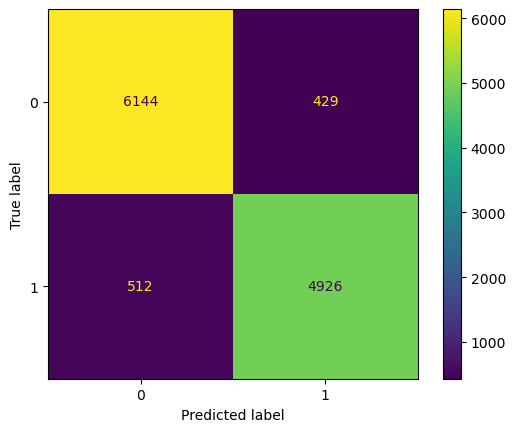

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm_log = confusion_matrix( y_test, test_predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_log,
                          display_labels=clf.classes_)
disp.plot()

plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, test_predictions))

              precision    recall  f1-score   support

           0       0.92      0.93      0.93      6573
           1       0.92      0.91      0.91      5438

    accuracy                           0.92     12011
   macro avg       0.92      0.92      0.92     12011
weighted avg       0.92      0.92      0.92     12011



### SVC

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
trained_clf_svc = LinearSVC().fit(x_train_embedded,y_train)
print("Training accuracy:", trained_clf_svc.score(x_train_embedded,y_train))
svc_y_pred = trained_clf_svc.predict(x_test_embedded)
print("test accuracy:", accuracy_score(y_test, svc_y_pred))

Training accuracy: 0.9614087673285875
test accuracy: 0.9197402381150612


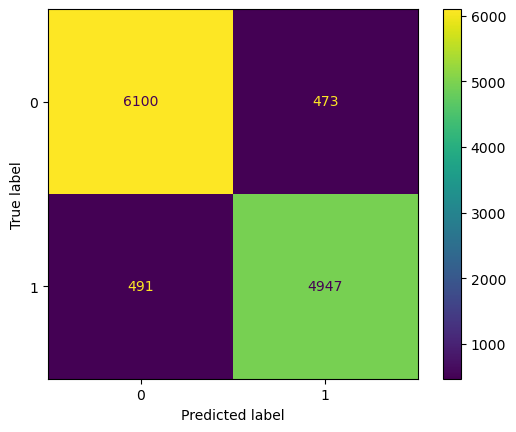

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm_svc = confusion_matrix( y_test, svc_y_pred, labels=trained_clf_svc.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svc,
                          display_labels=trained_clf_svc.classes_)
disp.plot()

plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, svc_y_pred))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      6573
           1       0.91      0.91      0.91      5438

    accuracy                           0.92     12011
   macro avg       0.92      0.92      0.92     12011
weighted avg       0.92      0.92      0.92     12011



### naive bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
NB_clf = GaussianNB()
NB_clf.fit(x_train_embedded,y_train)
print("Training accuracy:", NB_clf.score(x_train_embedded, y_train))
NB_y_pred = NB_clf.predict(x_test_embedded)
print("Testing accuracy   :",accuracy_score(NB_y_pred, y_test))

Training accuracy: 0.8558136630448357
Testing accuracy   : 0.8148363999666972


## TPU

In [35]:
import tensorflow as tf
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.69.15.202:8470


REPLICAS:  8


## Word Embedding


In [70]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, label_train, label_test = train_test_split(df['processed_text'], df['Rating'], test_size=0.1, random_state=42,shuffle=True)
# print("Training:", len(X_train))
# print("Testing: ", len(X_test))

In [114]:
df.dropna(inplace=True)

In [115]:
min_sample = df.groupby(['Rating']).count().processed_text.min()
input_data = pd.concat([df[df.Rating == 1].head(min_sample),
                        df[df.Rating == 0].head(min_sample)])

X = input_data.processed_text.astype('str').values #training paramter
Y = np.asarray(input_data.Rating.values).astype('float32') #prediction paramter
Y = Y.clip(0, 1)
X_train, X_test, label_train, label_test = train_test_split(df['processed_text'], df['Rating'], test_size=0.1, random_state=42,shuffle=True)

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
print("vocab size:",len(tokenizer.word_index))
X_train = pad_sequences(X_train, padding='post', maxlen=300)


print("Training:", len(X_train))
X_test = tokenizer.texts_to_sequences(X_test)
print("vocab size:",len(tokenizer.word_index))
X_test = pad_sequences(X_test, padding='post', maxlen=300)
print("Testing: ", len(X_test))

vocab size: 20385
Training: 35309
vocab size: 20385
Testing:  3924


In [130]:
import pickle
pickle.dump(tokenizer, open("Approach2_DL_English_Tokenizer_a5r_7aga.pk", "wb"))

# Data splitting


In [116]:
label_train = pd.get_dummies(label_train).values
label_test = pd.get_dummies(label_test).values

## RNN

In [69]:
%%time
with strategy.scope():
  dropout = 0.5
  opt = 'adam'
  SimpleRNN = Sequential()
  SimpleRNN.add(keras.layers.Embedding(input_dim=5000, output_dim=100, input_length=300))
  SimpleRNN.add(keras.layers.SimpleRNN(units=100, return_sequences=True))
  SimpleRNN.add(keras.layers.GlobalMaxPool1D())
  SimpleRNN.add(keras.layers.Dense(64, activation='relu'))
  SimpleRNN.add(keras.layers.Dense(32, activation='relu'))
  SimpleRNN.add(keras.layers.Dense(2, activation='softmax'))
  SimpleRNN.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
SimpleRNN.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 300, 100)          500000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 300, 100)          20100     
                                                                 
 global_max_pooling1d (Globa  (None, 100)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_21 (Dense)            (None, 64)                6464      
                                                                 
 dense_22 (Dense)            (None, 32)                2080      
                                                                 
 dense_23 (Dense)            (None, 2)                 66        
                                                      

In [70]:
history = SimpleRNN.fit(X_train, label_train, epochs=20, verbose=True,  validation_data=(X_test, label_test),batch_size=64*strategy.num_replicas_in_sync)
loss_val, accuracy_val = SimpleRNN.evaluate(X_test, label_test, verbose=True)
print("Testing Accuracy:  {:.4f}".format(accuracy_val))

Epoch 1/20
64/64 [==============================] - 14s 100ms/step - loss: 0.4865 - accuracy: 0.7449 - val_loss: 0.3152 - val_accuracy: 0.8692
Epoch 2/20
64/64 [==============================] - 3s 40ms/step - loss: 0.3071 - accuracy: 0.8805 - val_loss: 0.2965 - val_accuracy: 0.8825
Epoch 3/20
64/64 [==============================] - 3s 43ms/step - loss: 0.2603 - accuracy: 0.9026 - val_loss: 0.2766 - val_accuracy: 0.8902
Epoch 4/20
64/64 [==============================] - 3s 46ms/step - loss: 0.2133 - accuracy: 0.9250 - val_loss: 0.2780 - val_accuracy: 0.8927
Epoch 5/20
64/64 [==============================] - 3s 41ms/step - loss: 0.1830 - accuracy: 0.9404 - val_loss: 0.2858 - val_accuracy: 0.8924
Epoch 6/20
64/64 [==============================] - 3s 41ms/step - loss: 0.1806 - accuracy: 0.9404 - val_loss: 0.3100 - val_accuracy: 0.8852
Epoch 7/20
64/64 [==============================] - 3s 46ms/step - loss: 0.1643 - accuracy: 0.9473 - val_loss: 0.3085 - val_accuracy: 0.8899
Epoch 8/20


In [71]:
SimpleRNN.save('Approach2_English_SimpleRNN_Model.h5')

346/346 [==============================] - 6s 14ms/step


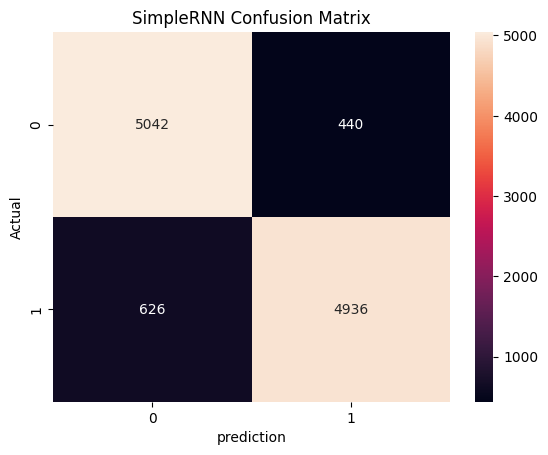

In [ ]:
y_pred=SimpleRNN.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
y_test_class=np.array(label_test)

SimpleRNN = confusion_matrix(y_test_class,y_pred)
sns.heatmap(SimpleRNN,annot=True,fmt = '.0f')
plt.xlabel('prediction')
plt.ylabel('Actual')
plt.title("SimpleRNN"+ ' Confusion Matrix')
plt.show()

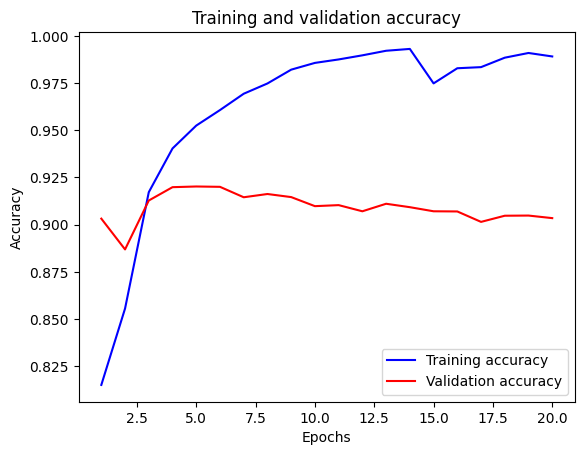

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(accuracy) + 1)

# Plot accuracy
plt.figure(1)
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


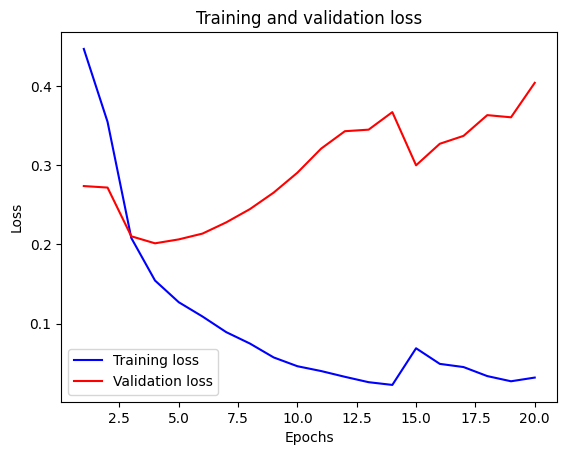

In [ ]:
# Plot loss
plt.figure(2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## CNN

In [73]:
with strategy.scope():
    embedding_dim = 70
    CNN_LSTM = Sequential()
    CNN_LSTM.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=embedding_dim, input_length=300))

    CNN_LSTM.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
    CNN_LSTM.add((LSTM(100, return_sequences=True)))
    CNN_LSTM.add(Flatten())
    CNN_LSTM.add(Dense(64, activation='relu'))
    CNN_LSTM.add(Dense(32, activation='relu'))
    CNN_LSTM.add(Dense(2, activation='softmax'))

    CNN_LSTM.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
    CNN_LSTM.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 300, 70)           1277920   
                                                                 
 conv1d_1 (Conv1D)           (None, 298, 32)           6752      
                                                                 
 lstm_4 (LSTM)               (None, 298, 100)          53200     
                                                                 
 flatten_1 (Flatten)         (None, 29800)             0         
                                                                 
 dense_27 (Dense)            (None, 64)                1907264   
                                                                 
 dense_28 (Dense)            (None, 32)                2080      
                                                                 
 dense_29 (Dense)            (None, 2)                

In [74]:
history6 = CNN_LSTM.fit(X_train, label_train, epochs=20, verbose=True,  validation_data=(X_test, label_test),batch_size=64*strategy.num_replicas_in_sync)
loss_val, accuracy_val = CNN_LSTM.evaluate(X_test, label_test, verbose=True)
print("Testing Accuracy:  {:.4f}".format(accuracy_val))

Epoch 1/20
64/64 [==============================] - 29s 249ms/step - loss: 0.4963 - accuracy: 0.7394 - val_loss: 0.2945 - val_accuracy: 0.8885
Epoch 2/20
64/64 [==============================] - 7s 103ms/step - loss: 0.2631 - accuracy: 0.9024 - val_loss: 0.2649 - val_accuracy: 0.9004
Epoch 3/20
64/64 [==============================] - 5s 86ms/step - loss: 0.2213 - accuracy: 0.9236 - val_loss: 0.2701 - val_accuracy: 0.9034
Epoch 4/20
64/64 [==============================] - 6s 92ms/step - loss: 0.1903 - accuracy: 0.9377 - val_loss: 0.2755 - val_accuracy: 0.8965
Epoch 5/20
64/64 [==============================] - 7s 104ms/step - loss: 0.1602 - accuracy: 0.9502 - val_loss: 0.3158 - val_accuracy: 0.8960
Epoch 6/20
64/64 [==============================] - 7s 104ms/step - loss: 0.1336 - accuracy: 0.9596 - val_loss: 0.3113 - val_accuracy: 0.8993
Epoch 7/20
64/64 [==============================] - 7s 104ms/step - loss: 0.1102 - accuracy: 0.9676 - val_loss: 0.3584 - val_accuracy: 0.8974
Epoch 8

In [75]:
CNN_LSTM.save('Approach2_English_CNN_LSTM_Model.h5')

346/346 [==============================] - 14s 39ms/step


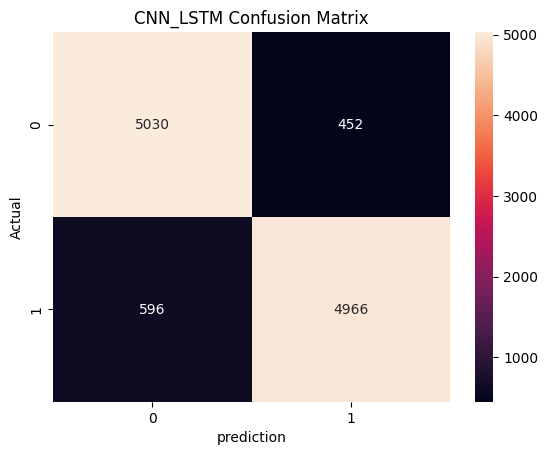

In [ ]:
y_pred6=CNN_LSTM.predict(X_test)
y_pred6 = (y_pred6 >= 0.5).astype(int)
y_test_class=np.array(label_test)

cnnlstm = confusion_matrix(y_test_class,y_pred6)
sns.heatmap(cnnlstm,annot=True,fmt = '.0f')
plt.xlabel('prediction')
plt.ylabel('Actual')
plt.title("CNN_LSTM"+ ' Confusion Matrix')
plt.show()

## LSTM

In [76]:
# LSTM model with keras
%%time
with strategy.scope():
    dropout = 0.5
    opt = 'adam'
    LSTM_model = Sequential()
    LSTM_model.add(Embedding(input_dim=5000, output_dim=100, input_length=300))
    LSTM_model.add(LSTM(100, dropout=0.5, recurrent_dropout=0.5, return_sequences=True))
    LSTM_model.add(LSTM(60, dropout=0.5, recurrent_dropout=0.5, return_sequences=True))
    LSTM_model.add(GlobalMaxPool1D())
    LSTM_model.add(Dense(32, activation='relu'))
    LSTM_model.add(Dropout(dropout))
    LSTM_model.add(Dense(2, activation='softmax'))

    LSTM_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    LSTM_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 300, 100)          500000    
                                                                 
 lstm_5 (LSTM)               (None, 300, 100)          80400     
                                                                 
 lstm_6 (LSTM)               (None, 300, 60)           38640     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 60)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_30 (Dense)            (None, 32)                1952      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                      

In [79]:
history2 = LSTM_model.fit(X_train, label_train, epochs=20, verbose=True,  validation_data=(X_test, label_test),batch_size=64*strategy.num_replicas_in_sync)
loss_val, accuracy_val = LSTM_model.evaluate(X_test, label_test, verbose=True)
print("Testing Accuracy:  {:.4f}".format(accuracy_val))

114/114 [==============================] - 8s 45ms/step - loss: 0.3024 - accuracy: 0.8946
Testing Accuracy:  0.8946


In [80]:
LSTM_model.save('Approach2_English_LSTM_model_Model.h5')

346/346 [==============================] - 11s 27ms/step


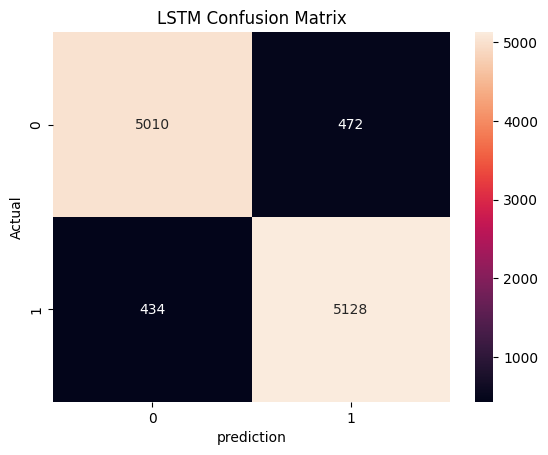

In [ ]:
y_pred2=model2.predict(X_test)
y_pred2 = (y_pred2 >= 0.5).astype(int)
y_test_class=np.array(label_test)

lstm = confusion_matrix(y_test_class,y_pred2)
sns.heatmap(lstm,annot=True,fmt = '.0f')
plt.xlabel('prediction')
plt.ylabel('Actual')
plt.title("LSTM"+ ' Confusion Matrix')
plt.show()

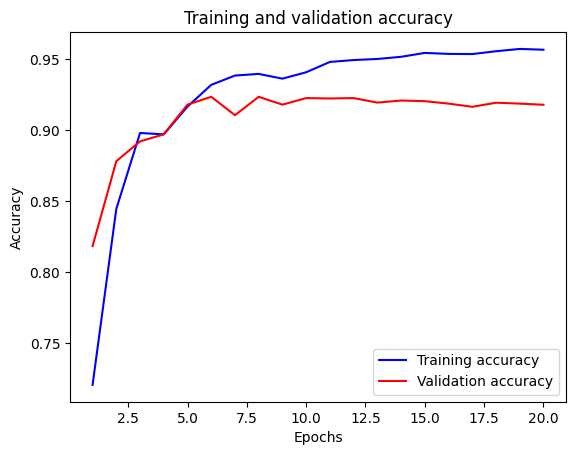

In [ ]:
accuracy = history2.history['accuracy']
val_accuracy = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs = range(1,len(accuracy) + 1)

# Plot accuracy
plt.figure(1)
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


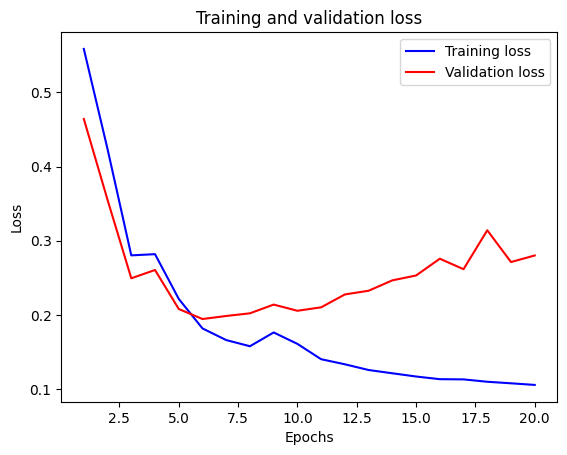

In [ ]:
# Plot loss
plt.figure(2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## BILSTM

In [118]:
%%time
with strategy.scope():
    embedding_dim = 100
    biLSTM = Sequential()
    biLSTM.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=embedding_dim, input_length=300))
    biLSTM.add(Bidirectional(LSTM(64)))
    biLSTM.add(Dense(128, activation='relu'))
    biLSTM.add(Dense(96, activation='relu'))

    biLSTM.add(Dense(64, activation='relu'))
    biLSTM.add(Dropout(0.5))
    biLSTM.add(Dense(32, activation='relu'))
    biLSTM.add(Dense(16, activation='relu'))
    biLSTM.add(Dense(2, activation='softmax'))

    from keras import optimizers
    optimizer = optimizers.Adam(learning_rate=0.0001)
    biLSTM.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    biLSTM.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 300, 100)          2038600   
                                                                 
 bidirectional_6 (Bidirectio  (None, 128)              84480     
 nal)                                                            
                                                                 
 dense_43 (Dense)            (None, 128)               16512     
                                                                 
 dense_44 (Dense)            (None, 96)                12384     
                                                                 
 dense_45 (Dense)            (None, 64)                6208      
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                     

In [119]:
biLSTM_history = biLSTM.fit(X_train, label_train, epochs=20,batch_size=64*strategy.num_replicas_in_sync,validation_data=(X_test, label_test))

Epoch 1/20
69/69 [==============================] - 29s 279ms/step - loss: 0.6852 - accuracy: 0.5883 - val_loss: 0.6673 - val_accuracy: 0.5991
Epoch 2/20
69/69 [==============================] - 12s 170ms/step - loss: 0.6452 - accuracy: 0.6185 - val_loss: 0.5824 - val_accuracy: 0.7217
Epoch 3/20
69/69 [==============================] - 12s 171ms/step - loss: 0.5029 - accuracy: 0.7792 - val_loss: 0.3787 - val_accuracy: 0.8420
Epoch 4/20
69/69 [==============================] - 12s 172ms/step - loss: 0.3493 - accuracy: 0.8677 - val_loss: 0.3159 - val_accuracy: 0.8828
Epoch 5/20
69/69 [==============================] - 12s 171ms/step - loss: 0.3048 - accuracy: 0.8901 - val_loss: 0.2981 - val_accuracy: 0.8930
Epoch 6/20
69/69 [==============================] - 12s 175ms/step - loss: 0.2800 - accuracy: 0.9029 - val_loss: 0.2921 - val_accuracy: 0.8991
Epoch 7/20
69/69 [==============================] - 12s 173ms/step - loss: 0.2668 - accuracy: 0.9092 - val_loss: 0.2885 - val_accuracy: 0.8986

In [129]:
biLSTM.save('Approach2_English_BILSTM_Model.h5')

In [132]:
df_preprocessor = TextPreprocessor()
import random

reviews3 = [
    "Amazing mobile phone! Stunning camera, long-lasting battery, vibrant display, sleek design. Worth the price.",
    "Happy with new laptop. Super fast, great for multitasking. Comfortable keyboard, impressive battery life. Perfect for work and entertainment.",
    "Fantastic tablet! Sharp display, smooth performance. Lightweight and portable. Loving it!",
    "Excellent headphones! Top-notch sound quality, comfortable to wear. Flawless wireless connectivity, impressive battery life. Highly recommended.",
    "Pleased with new mobile phone. Smooth performance, great camera. Decent battery life, sharp display. Solid device.",
    "Disappointed with mobile phone. Below-average camera, quick battery drain. Cheap design, sluggish performance. Expected better.",
    "Regret buying laptop. Slow, frequent freezes. Poor battery life, uncomfortable keyboard. Not worth the money.",
    "Not happy with tablet. Mediocre display, laggy performance. Fast battery drain, overall disappointing.",
    "Letdown headphones. Subpar sound quality, uncomfortable to wear. Unstable wireless connection, short battery life. Not recommended.",
    "Issues with mobile phone. Freezing and crashing. Average camera, below-expectations battery life. Wouldn't purchase again."
]


# reviews = positive_reviews + negative_reviews
# random.shuffle(reviews)

# reviews = positive_reviews + negative_reviews
testing = [df_preprocessor.preprocessing(text) for text in reviews3]
# print(testing)
result=[]
for test in testing:
    result.append(' '.join(test))
result

['mobile camera longlasting Amazing vibrant sleek Worth Stunning display design phone battery price',
 'great laptop life Perfect work multitasking new Happy Comfortable entertainment keyboard battery fast Super impressive',
 'Fantastic Loving performance Lightweight display smooth Sharp portable tablet',
 'wear life impressive quality Excellent connectivity Highly comfortable recommended wireless headphone battery Flawless sound Topnotch',
 'mobile great camera life sharp Solid device performance Smooth Pleased display new phone Decent battery',
 'mobile camera drain quick Belowaverage performance Disappointed better Cheap design phone sluggish Expected battery',
 'laptop life Poor money uncomfortable frequent Not Slow Regret buying freeze worth keyboard battery',
 'Fast drain Not overall performance display disappointing laggy happy battery Mediocre tablet',
 'wear Unstable life uncomfortable quality short Subpar Not headphone recommended wireless Letdown connection battery sound',
 

In [133]:
test = tokenizer.texts_to_sequences(result)
print("vocab size:",len(tokenizer.word_index))
test = pad_sequences(test, padding='post', maxlen=300)
print("Testing: ", len(test))


vocab size: 20385
Testing:  10


In [134]:
# from tensorflow import keras

# model = keras.models.load_model('bi_lstm _test.h5')


In [135]:
result = np.array(test)

# Create an empty list to store the predictions
pred = []
class_labels=[0,1]
# Iterate over each row in the result
for row in result:
    # Reshape the row to match the expected input shape of the model
    row = np.reshape(row, (1, len(row)))

    # Make a prediction using the model
    y_pred2 = biLSTM.predict(row, batch_size=1, verbose=2)[0]
    y_pred2 = np.argmax(y_pred2)

    # Get the predicted class label
    predicted_label = class_labels[y_pred2]

    # Append the predicted label to the pred list
    pred.append(predicted_label)

print(pred)

1/1 - 2s - 2s/epoch - 2s/step
1/1 - 3s - 3s/epoch - 3s/step
1/1 - 5s - 5s/epoch - 5s/step
1/1 - 2s - 2s/epoch - 2s/step
1/1 - 1s - 1s/epoch - 1s/step
1/1 - 1s - 1s/epoch - 1s/step
1/1 - 2s - 2s/epoch - 2s/step
1/1 - 1s - 950ms/epoch - 950ms/step
1/1 - 1s - 1s/epoch - 1s/step
1/1 - 2s - 2s/epoch - 2s/step
[1, 1, 1, 1, 1, 0, 0, 0, 0, 0]


In [53]:
df_test=pd.DataFrame()
df_test['Reviews']=reviews
df_test['prediction']=pred
df_test

,Reviews,prediction
0,This phone is absolutely amazing! The camera q...,1
1,The performance of this phone is absolutely mi...,0
2,This phone possesses a sleek and stylish desig...,1
3,The audio quality on this phone is simply phen...,1
4,The phone's user interface is immensely intuit...,1
5,I'm utterly disappointed with the abysmal batt...,0
6,The camera on this phone utterly fails to meet...,0
7,This phone tends to excessively overheat durin...,0
8,I've encountered distressingly frequent softwa...,0
9,The build quality of this phone is shockingly ...,0


346/346 [==============================] - 9s 20ms/step


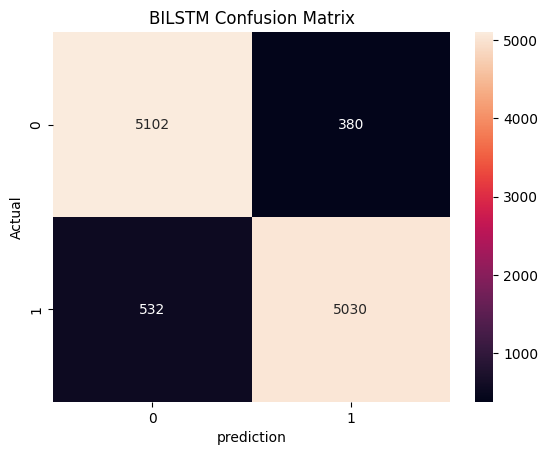

In [ ]:
# y_pred=biLSTM.predict(X_test)
# y_pred = (y_pred >= 0.5).astype(int)
# y_test_class=np.array(label_test)

# lstm = confusion_matrix(y_test_class,y_pred)
# sns.heatmap(lstm,annot=True,fmt = '.0f')
# plt.xlabel('prediction')
# plt.ylabel('Actual')
# plt.title("BILSTM"+ ' Confusion Matrix')
# plt.show()

In [88]:
df_preprocessor = TextPreprocessor()

In [ ]:

test=df_preprocessor.preprocessing("cameras quality sucks")
result = ' '.join(test)
result=tokenizer.texts_to_sequences(result)
result = pad_sequences(result, padding='post', maxlen=300)
y_pred2 = biLSTM.predict(result,batch_size=1,verbose = 2)[0]
y_pred2 = np.argmax(y_pred2)
if y_pred2 ==0:
    class_label = 'Negative'
else:
    class_label = 'Positive'
print("Predicted class:", class_label)


19/19 - 1s - 810ms/epoch - 43ms/step
Predicted class: Negative


In [ ]:
test=df_preprocessor.preprocessing("The phone's starting to have a late response")
result = ' '.join(test)
result=tokenizer.texts_to_sequences(result)
result = pad_sequences(result, padding='post', maxlen=300)
y_pred2 = biLSTM.predict(result,batch_size=1,verbose = 2)[0]
y_pred2 = np.argmax(y_pred2)
if y_pred2 ==0:
    class_label = 'Negative'
else:
    class_label = 'Positive'
print("Predicted class:", class_label)


28/28 - 0s - 233ms/epoch - 8ms/step
Predicted class: Negative


In [99]:
test=df_preprocessor.preprocessing("this phone is very bad")
result = ' '.join(test)
result=tokenizer.texts_to_sequences(result)
result = pad_sequences(result, padding='post', maxlen=300)
y_pred2 = biLSTM.predict(result,batch_size=1,verbose = 2)[0]
y_pred2 = np.argmax(y_pred2)
if y_pred2 ==0:
    class_label = 'Negative'
else:
    class_label = 'Positive'
print("Predicted class:", class_label)


9/9 - 1s - 1s/epoch - 114ms/step
Predicted class: Positive


In [100]:
test=df_preprocessor.preprocessing("the display is good")
result = ' '.join(test)
result=tokenizer.texts_to_sequences(result)
result = pad_sequences(result, padding='post', maxlen=300)
y_pred2 = biLSTM.predict(result,batch_size=1,verbose = 2)[0]
y_pred2 = np.argmax(y_pred2)
if y_pred2 ==0:
    class_label = 'Negative'
else:
    class_label = 'Positive'
print("Predicted class:", class_label)


12/12 - 1s - 984ms/epoch - 82ms/step
Predicted class: Positive


In [101]:
test=df_preprocessor.preprocessing("Quality of product is lower than expected")
result = ' '.join(test)
result=tokenizer.texts_to_sequences(result)
result = pad_sequences(result, padding='post', maxlen=300)
y_pred2 = biLSTM.predict(result,batch_size=1,verbose = 2)[0]
y_pred2 = np.argmax(y_pred2)
if y_pred2 ==0:
    class_label = 'Negative'
else:
    class_label = 'Positive'
print("Predicted class:", class_label)


30/30 - 1s - 1s/epoch - 40ms/step
Predicted class: Negative


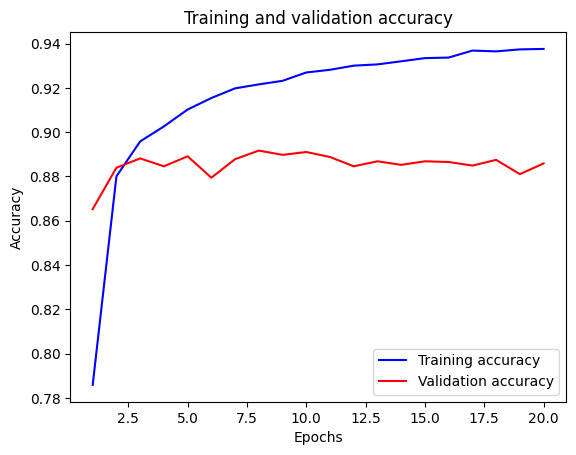

In [ ]:
accuracy = biLSTM_history.history['accuracy']
val_accuracy = biLSTM_history.history['val_accuracy']
loss = biLSTM_history.history['loss']
val_loss = biLSTM_history.history['val_loss']

epochs = range(1,len(accuracy) + 1)

# Plot accuracy
plt.figure(1)
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

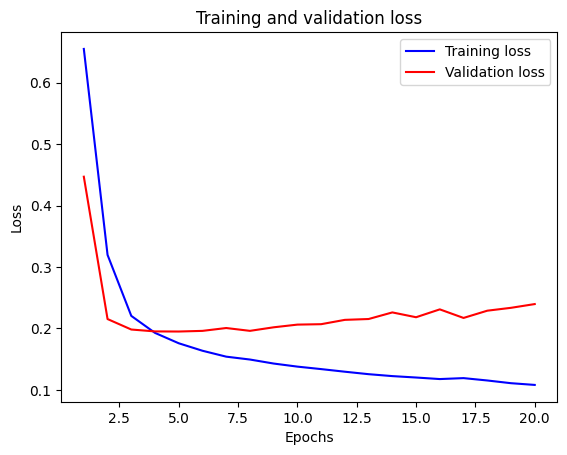

In [ ]:
# Plot loss
plt.figure(2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Bidirectional GRU

In [84]:
%%time
with strategy.scope():
  #create BIGRU model with keras
  dropout = 0.5
  opt = 'adam'
  # clear_session()
  BIGRU = Sequential()
  BIGRU.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=100, input_length=300))
  # model.add(keras.layers.Bidirectional(keras.layers.GRU(100, dropout=0.5, recurrent_dropout=0.5, return_sequences=True)))
  BIGRU.add(Bidirectional(GRU(64)))
  BIGRU.add(Dense(128, activation='relu'))
  BIGRU.add(Dense(64, activation='relu'))
  BIGRU.add(Dropout(0.5))
  BIGRU.add(Dense(32, activation='relu'))
  BIGRU.add(Dense(16, activation='relu'))
  BIGRU.add(Dense(2, activation='softmax'))
  BIGRU.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
BIGRU.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 300, 100)          1825600   
                                                                 
 bidirectional_5 (Bidirectio  (None, 128)              63744     
 nal)                                                            
                                                                 
 dense_38 (Dense)            (None, 128)               16512     
                                                                 
 dense_39 (Dense)            (None, 64)                8256      
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_40 (Dense)            (None, 32)                2080      
                                                      

In [85]:
history_BIGRU = BIGRU.fit(X_train, label_train, epochs=20, verbose=True,  validation_data=(X_test, label_test),batch_size=64*strategy.num_replicas_in_sync)


Epoch 1/20
64/64 [==============================] - 28s 286ms/step - loss: 0.5037 - accuracy: 0.7408 - val_loss: 0.3105 - val_accuracy: 0.8772
Epoch 2/20
64/64 [==============================] - 11s 174ms/step - loss: 0.3070 - accuracy: 0.8860 - val_loss: 0.2835 - val_accuracy: 0.8896
Epoch 3/20
64/64 [==============================] - 11s 174ms/step - loss: 0.2604 - accuracy: 0.9097 - val_loss: 0.2783 - val_accuracy: 0.8968
Epoch 4/20
64/64 [==============================] - 11s 177ms/step - loss: 0.2338 - accuracy: 0.9208 - val_loss: 0.2639 - val_accuracy: 0.9018
Epoch 5/20
64/64 [==============================] - 11s 171ms/step - loss: 0.2145 - accuracy: 0.9287 - val_loss: 0.2676 - val_accuracy: 0.9004
Epoch 6/20
64/64 [==============================] - 11s 172ms/step - loss: 0.2045 - accuracy: 0.9323 - val_loss: 0.2696 - val_accuracy: 0.9020
Epoch 7/20
64/64 [==============================] - 11s 172ms/step - loss: 0.1888 - accuracy: 0.9375 - val_loss: 0.2721 - val_accuracy: 0.9048

In [86]:
loss_val, accuracy_val = BIGRU.evaluate(X_test, label_test, verbose=True)
print("Testing Accuracy:  {:.4f}".format(accuracy_val))

114/114 [==============================] - 5s 32ms/step - loss: 0.4491 - accuracy: 0.8960
Testing Accuracy:  0.8960


In [87]:
BIGRU.save('Approach2_English_BIGRU_Model.h5')


346/346 [==============================] - 11s 22ms/step


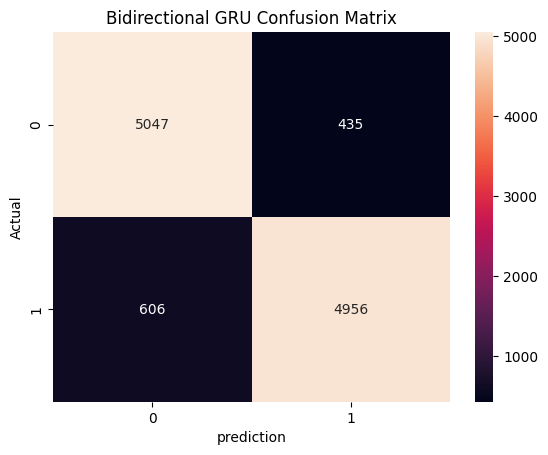

In [ ]:
y_pred=BIGRU.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
y_test_class=np.array(label_test)

GRU = confusion_matrix(y_test_class,y_pred)
sns.heatmap(GRU,annot=True,fmt = '.0f')
plt.xlabel('prediction')
plt.ylabel('Actual')
plt.title("Bidirectional GRU"+ ' Confusion Matrix')
plt.show()

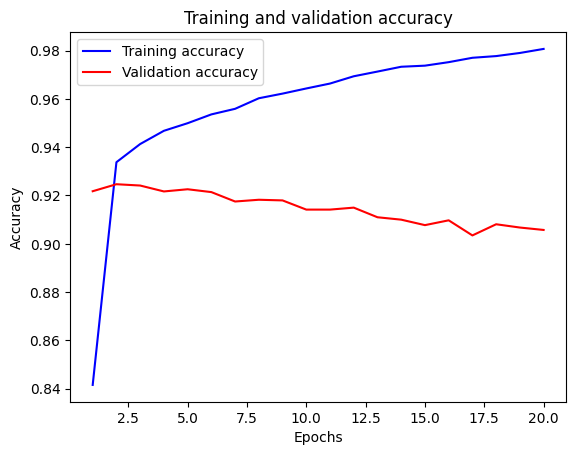

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(accuracy) + 1)

# Plot accuracy
plt.figure(1)
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

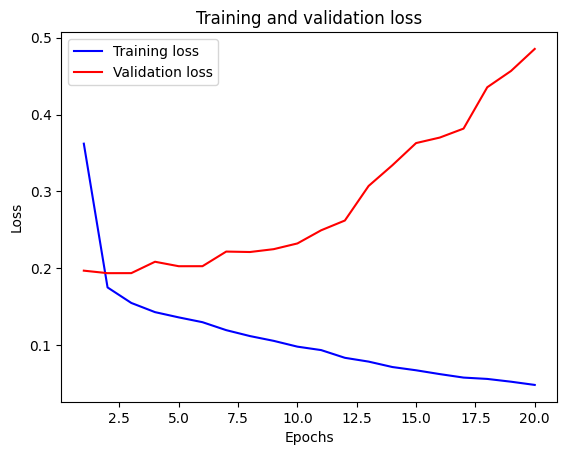

In [ ]:
# Plot loss
plt.figure(2)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()